1. Тестовое задание заключается в том что бы определить по последовательности посещенных сайтов, 
что сессия принадлежит одному человеку(для простоты бкдем называть его Иван)
 
В выборке train_sessions.csv:
 
site_i – это индексы посещенных сайтов (текстовая расшифровка в pickle-файле site_dic.pkl)
time_j – время посещения сайтов site_j
target – целевая переменная, факт того что именно Иван ходил по всем этим сайтам)
 
Задача – Нагенерировать признаки, сделать их визуализацию и попробовать построить модель для определения 
Ивана(Это не главная задача, главное-признаки). По возможности обосновать выбор той или иной модели и метрики качества.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from scipy.sparse import csr_matrix, hstack

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def visualize(df, feature):
    '''Countplot визуализация фич в разрезе Alice\Others'''
    
    plt.subplots(1, 2, figsize = (12, 4)) 
    plt.subplot(1, 2, 1)
    sns.countplot(df[df.target == 1][feature])            
    plt.title("Alice")
    plt.xlabel(str(feature))
    plt.subplot(1, 2, 2)
    sns.countplot(df[df.target == 0][feature])
    plt.title('Others')
    plt.xlabel(str(feature));   

In [3]:
def simple_valid_auc(X, y):
    ''' roc-auc на валидации train_test_split (test_size=0.2)'''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LogisticRegression(solver='liblinear', random_state=0, max_iter=500)
    clf.fit(X_train, y_train)
    predicts = clf.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, predicts)

In [4]:
def cross_valid_auc(X, y, C=1, cv=5):
    ''' roc-auc на кросс-валидации'''
    
    clf = LogisticRegression(solver='liblinear', C=C, random_state=0, max_iter=500)
    curr_cv = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    print('{}-fold CV is : {} +/- {}'.format(cv, curr_cv.mean().round(4), curr_cv.std().round(4)))
    # return(curr_cv.mean().round(4), curr_cv.std().round(4))

In [5]:
df = pd.read_csv('train_sessions.csv')
df.head(3)

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
2,3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0


In [6]:
times = ['time' + str(i) for i in range(1, 11)]
sites = ['site' + str(i) for i in range(1, 11)]
diffs = ['diff' + str(i) for i in range(2, 11)]

### подход 1 
будем исходить из того, что Alice посещает сайты примерно в одно и тоже время

In [7]:
#переведем время в формат to_datetime
df[times] = df[times].apply(pd.to_datetime)

#новый df для создания новых признаков(фич)
new_feat_df = pd.DataFrame(index=df.index)
new_feat_df['target'] = df.target

In [8]:
#день недели, выходные(пт,сб,вс), время начала сессии
new_feat_df['dayofweek'] = df.time1.apply(lambda x: x.dayofweek)
new_feat_df['is_weekend'] = new_feat_df.dayofweek.apply(lambda x: 1 if x > 4 else 0)
new_feat_df['start_hour'] = df.time1.apply(lambda x: x.hour)

In [9]:
#разделение на время суток
new_feat_df['is_morning'] = (new_feat_df.start_hour <= 11).astype('int')
new_feat_df['is_afternoon'] = ((new_feat_df['start_hour'] > 11) & (new_feat_df['start_hour'] <= 15)).astype('int')
new_feat_df['allice_rushhour'] = ((new_feat_df['start_hour'] > 15) & (new_feat_df['start_hour'] <= 18)).astype('int')
new_feat_df['is_evening'] =  ((new_feat_df['start_hour'] > 18) & (new_feat_df['start_hour'] < 24)).astype('int')

In [10]:
#считаем разницу времени между сайтами
for i in tqdm_notebook(range(1,10)):
    column = ('diff' + str(i+1))
    new_feat_df[column] = (df['time' + str(i+1)] - df['time' + str(i)])
    new_feat_df[column] = new_feat_df[column].apply(lambda x: x.seconds)

In [11]:
# количество посещенных сайтов
new_feat_df['number_sites'] = new_feat_df[diffs].count(axis=1) + 1

# суммарное время, среднее, дисперсия
new_feat_df['time_diff_sum'] = new_feat_df[diffs].sum(axis=1)
new_feat_df['time_diff_mean'] = new_feat_df[diffs].mean(axis=1)
new_feat_df['time_diff_std'] = new_feat_df[diffs].std(axis=1)

In [12]:
#заполним пропущенные значения -1 и приведем данные к целочисленному виду
new_feat_df[diffs] = new_feat_df[diffs].fillna(-1).astype('int')

In [13]:
new_feat_df.head(3)

,target,dayofweek,is_weekend,start_hour,is_morning,is_afternoon,allice_rushhour,is_evening,diff2,diff3,...,diff5,diff6,diff7,diff8,diff9,diff10,number_sites,time_diff_sum,time_diff_mean,time_diff_std
0,0,3,0,10,1,0,0,0,-1,-1,...,-1,-1,-1,-1,-1,-1,1,0.0,NaN,NaN
1,0,5,1,11,1,0,0,0,0,1,...,0,0,1,0,23,1,10,26.0,2.888889,7.557189
2,0,0,0,16,0,0,1,0,1,1,...,0,0,1,1,1,2,10,7.0,0.777778,0.666667


In [14]:
new_feat_df.columns

Index(['target', 'dayofweek', 'is_weekend', 'start_hour', 'is_morning',
       'is_afternoon', 'allice_rushhour', 'is_evening', 'diff2', 'diff3',
       'diff4', 'diff5', 'diff6', 'diff7', 'diff8', 'diff9', 'diff10',
       'number_sites', 'time_diff_sum', 'time_diff_mean', 'time_diff_std'],
      dtype='object')

In [15]:
feature_for_visual = ['dayofweek', 'is_weekend', 'start_hour', 'is_morning','is_afternoon', 'is_evening', 'number_sites']

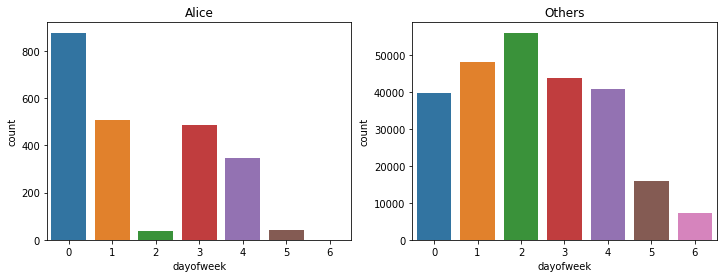

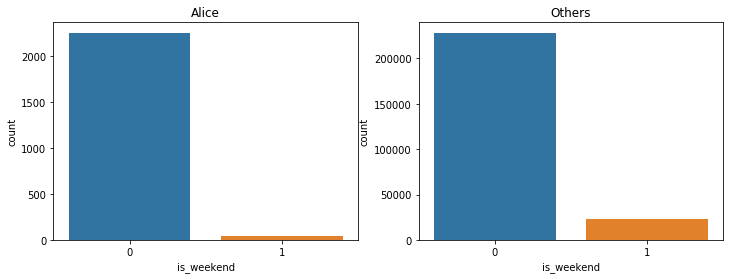

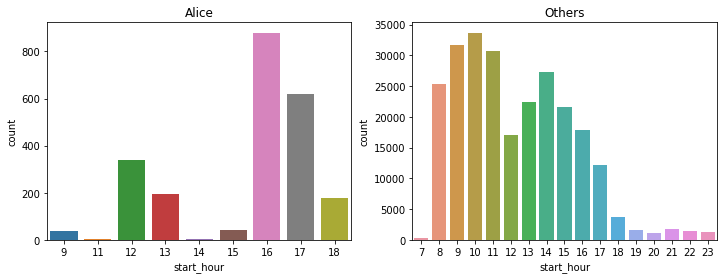

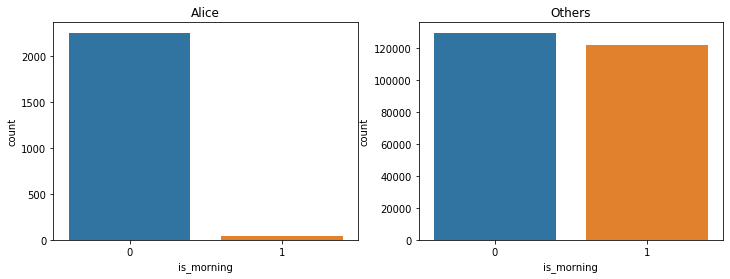

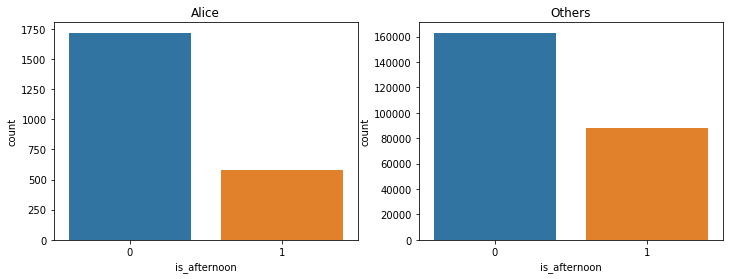

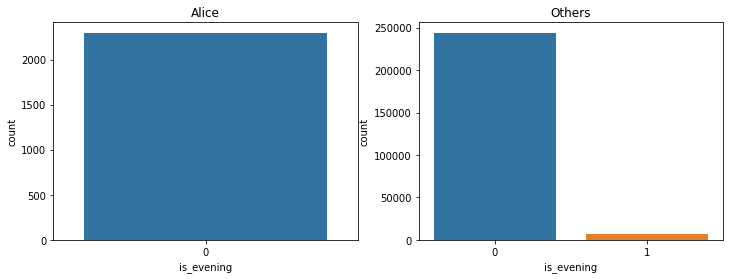

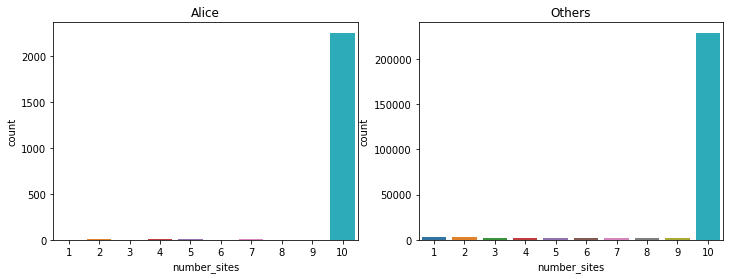

In [16]:
for feature_name in feature_for_visual:
    visualize(new_feat_df, feature_name)

In [17]:
# заполним пустые значения
new_feat_df[['time_diff_mean','time_diff_std']] = new_feat_df[['time_diff_mean','time_diff_std']].fillna(0)

# выделим Х,y
X = new_feat_df.drop('target', axis=1)
y = new_feat_df['target']

# отмасштабируем размерность признаков
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

In [18]:
simple_valid_auc(X_scale, y)

0.8974195793592417

In [19]:
cross_valid_auc(X_scale, y)

5-fold CV is : 0.8985 +/- 0.0063


<b> roc-auc 0.8985 на кроссвалидации

### подход 2
Будем исходить из того, что у Allice есть любимые сайты, которые она чаще всего посещает. Создадим разреженную матрицу, где каждый признак будет соответствовать одному сайту

In [20]:
sites_df = df[sites].fillna(0).astype('int')
sites_df.head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
0,718,0,0,0,0,0,0,0,0,0
1,890,941,3847,941,942,3846,3847,3846,1516,1518
2,14769,39,14768,14769,37,39,14768,14768,14768,14768


In [21]:
sites_flatten = sites_df.values.flatten()

sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

In [22]:
simple_valid_auc(sites_sparse, y)

0.9634399497062797

In [23]:
cross_valid_auc(sites_sparse, y)

5-fold CV is : 0.9639 +/- 0.0014


<b> roc-auc на кросс-валидации 0.9639

## объединение подхода 1 и 2

In [24]:
all_features = csr_matrix(hstack([sites_sparse, X_scale.reshape(-1,20)]))

In [25]:
simple_valid_auc(all_features, y)

0.9847159399725157

In [26]:
cross_valid_auc(all_features, y)

5-fold CV is : 0.983 +/- 0.0017


<b> итоговый roc-auc на кросс-валидации 0.983